<a href="https://colab.research.google.com/github/wangtzi/Pytorch/blob/main/MNIST_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


# 加載MNIST數據集( ToTensor() )
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# 將圖像數據展平為一維向量，scikit-learn只能讀numpy()
X_train = train_dataset.data.reshape(len(train_dataset), -1).numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.reshape(len(test_dataset), -1).numpy()
y_test = test_dataset.targets.numpy()

# 設定參數網格
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}


# 建立隨機森林分類器
rf_clf = RandomForestClassifier()

# 使用 HalvingGridSearchCV 尋找最佳參數
"""cv=3: 使用 3 折交叉驗證來評估模型性能。
factor=3: 每次迭代時將資源預算乘以 3。
min_resources="exhaust": 搜索將一直持續到耗盡所有資源或僅剩一個參數組合。
max_resources=500: 最大資源預算為 500 棵決策樹。
n_jobs=-1: 使用所有可用的 CPU 核心進行並行計算。
verbose=2: 顯示詳細的搜索過程信息。
"""
halving_cv = HalvingGridSearchCV(rf_clf,
                  param_grid,
                  cv=3,
                  factor=3,
                  min_resources="exhaust",
                  max_resources=500,
                  n_jobs=-1,
                  verbose=2)
halving_cv.fit(X_train, y_train)

# 打印最佳參數和分數
print(f"Best Parameters: {halving_cv.best_params_}")
print(f"Best Score: {halving_cv.best_score_:.4f}")

# 使用最佳參數訓練模型
best_rf_clf = halving_cv.best_estimator_
best_rf_clf.fit(X_train, y_train)


# 訓練模型
#rf_clf.fit(X_train, y_train)

# 在測試集上進行預測
#y_pred = rf_clf.predict(X_test)
y_pred = best_rf_clf.predict(X_test)

# 計算準確率
accuracy = (y_pred == y_test).mean()
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Save >>
torch.save(best_rf_clf, 'model.pth')
# Load >>
#best_rf_clf = torch.load('model.pth')

100%|██████████| 9912422/9912422 [00:00<00:00, 327323990.05it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 90942713.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 154262388.40it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19165521.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

n_iterations: 2
n_required_iterations: 5
n_possible_iterations: 2
min_resources_: 60
max_resources_: 500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 60
Fitting 3 folds for each of 81 candidates, totalling 243 fits
----------
iter: 1
n_candidates: 27
n_resources: 180
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.6833
Random Forest Accuracy: 0.9700


True Label: 2
Prediction: 2


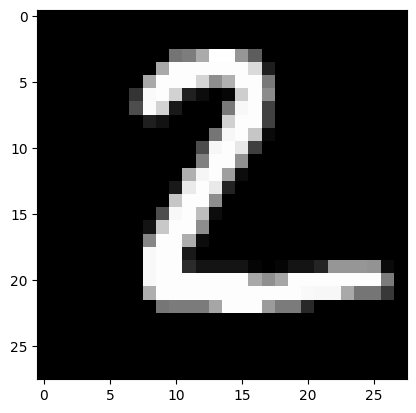

In [7]:
import matplotlib.pyplot as plt

test_idx = 1  # 要查看的測試數據索引
img = test_dataset.data[test_idx].numpy()
label = test_dataset.targets[test_idx].numpy()
prediction = best_rf_clf.predict(X_test[test_idx].reshape(1, -1))[0]

print(f"True Label: {label}")
print(f"Prediction: {prediction}")

plt.imshow(img, cmap='gray')
plt.show()

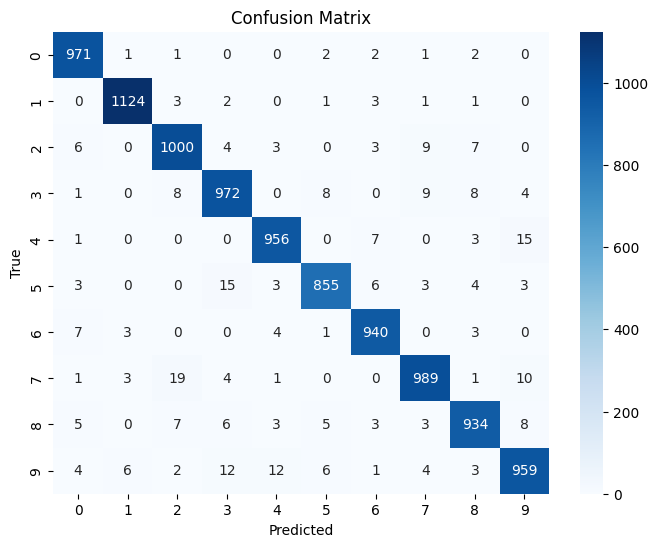

In [8]:
# Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

confused_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confused_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [9]:
from sklearn.tree import export_graphviz
import graphviz
# 獲取其中一棵決策樹的estimator對象
estimator = best_rf_clf.estimators_[0]

# 使用export_graphviz函數導出決策樹
dot_data = export_graphviz(estimator, out_file=None,
                           feature_names=['pixel_' + str(i) for i in range(784)],
                           class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                           filled=True, rounded=True)

# 使用graphviz渲染決策樹
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

'decision_tree.pdf'